# Train autoeconder using specific time datasets and checking autoencoder error for various day and hours.

In [1]:
from hdfs import InsecureClient
from pprint import pprint
import random
import time

import tensorflow as tf
print(tf.__version__)

from multilayerp import MultilayerPerceptron

import dataset_utils2 as ds
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline
%load_ext autoreload
%autoreload 2

1.0.0


In [2]:
def modify_flow(flow):
    for feature in ['syn_cnt', 'push_cnt', 'rst_cnt', 'fin_cnt']:
        if feature in flow:
            new_property = feature.replace('cnt','prop')
            setattr(flow, new_property, 1.0*getattr(flow, feature)/flow.pkts_cnt)
            delattr(flow, feature)
    del flow.src_ip
    del flow.dst_ip
    return flow

def skip_ipv6(flow):
    # skip IPv6 which remains as strings. IPv4 are floats
    for feature in ['src_ip', 'dst_ip']:
        if type(getattr(flow, feature)) is str:
            return True
                    
def skip_ddos(flow):    
    # skip flows which most probably are DDoS
    for feature in ['syn_cnt', 'rst_cnt', 'fin_cnt']:
        if feature in flow._fields and getattr(flow, feature)/flow.pkts_cnt > 0.8:
            return True

** Create HDSF client and gets all datasets **

In [3]:
hdfs = InsecureClient('http://hs-01.ipa.psnc.pl:50070', timeout=(10,10))

In [4]:
datasets = ds.get_datasets(hdfs, "/data/ddos_examples/2017_Apr_07")
pprint(datasets)

defaultdict(None,
            {'Pozman+RSTflood': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-35-16-2017.csv',
             'Pozman+SYNflood-HTTP': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-14-59-08-2017.csv',
             'Pozman+SYNflood-HTTP-2a': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-03-45-2017.csv',
             'Pozman+SYNflood-HTTP-2b': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-16-04-11-2017.csv',
             'Pozman+SYNfloodFIN': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-07-24-2017.csv',
             'Pozman+SYNfloodRST': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-06-08-2017.csv',
             'Pozman-1': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-39-53-2017.csv',
             'Pozman-2': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-40-12-2017.csv',
             'Pozman-3': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-40-29-2017.csv',
             'Pozman-4': '/data/ddos_examples/2017_Apr_07/

** Present example of the flow **

In [5]:
ds.print_dataset_flow(hdfs, datasets)

                    flow_index	67164
            reverse_flow_index	-1
                        src_ip	95.164
                src_ip_country	UA
                   src_ip_city	Kiev
                        dst_ip	150.254
                dst_ip_country	PL
                   dst_ip_city	Poznan
                      src_port	0
                      dst_port	0
                   ip_protocol	6
                  traffic_type	192
                          vlan	401
                      pkts_cnt	8
               first_timestamp	3700559165.2008224
                last_timestamp	3700559168.155535
         min_interarrival_time	66280
         max_interarrival_time	768604
        mean_interarrival_time	363874.86
     std_dev_interarrival_time	305027.41
       list_interarrival_times	[66541, 768604, 428822, 66280, 760280, 326679, 129918]
                     bytes_cnt	544
             min_packet_length	68
             max_packet_length	68
            mean_packet_length	68.0
         std_dev_packet_len

## Autoencoder over a mix of flow features

** Flow features chosen **

In [6]:
features = ds.get_features_names(hdfs, datasets['Pozman-1'])
to_removal = ['flow_index', 'reverse_flow_index', 'vlan', 'first_timestamp', 'last_timestamp', 'hop_cnt',
              'list_tcp_flags', 'list_packet_length', 'list_interarrival_times', 'src_ip_country',
              'src_ip_city', 'dst_ip_country', 'dst_ip_city', 'src_port', 'dst_port', 
              'src_port_entropy', 'dst_port_entropy', 'src_ip_entropy', 
              'min_interarrival_time', 'max_interarrival_time', 'mean_interarrival_time', 'std_dev_interarrival_time']
features = [feature for feature in features if feature not in to_removal]

skip_list = [skip_ipv6,] #skip_poznan

** Prepare train datasets basing on a set of normal POZMAN traffic from 7 April 2017 **

In [7]:
files = [datasets['Pozman-%i'%i] for i in range(1, 6)]

traindata, _features, borders = ds.prepare_datasets(hdfs, files, features, 
                                           flow_modification_f=modify_flow, 
                                           skip_flow_f=skip_list + [skip_ddos])
print("Flow features are [%i]: %s" % (len(_features), _features))

Skipped flows: 6565 from 31857 (20.61%)
Skipped flows: 6264 from 30943 (20.24%)
Skipped flows: 6205 from 31137 (19.93%)
Skipped flows: 6417 from 31401 (20.44%)
Skipped flows: 6404 from 30911 (20.72%)
Flow features are [22]: ('src_port_cnt', 'bytes_cnt', 'min_payload_byte', 'max_packet_length', 'pkts_cnt', 'dst_port_cnt', 'src_ip_cnt', 'mean_payload_byte', 'syn_prop', 'min_packet_length', 'fin_prop', 'mean_packet_length', 'push_prop', 'byte_distribution_entropy', 'ip_protocol', 'std_dev_packet_length', 'tcp_flags', 'total_datalen', 'max_payload_byte', 'rst_prop', 'traffic_type', 'std_dev_payload_byte')


** Prepare Encoder and use it on train datasets **

In [8]:
def train_autoencoder(traindata):
    # Define the size of the neural network
    n_input = len(traindata[0])
    n_hidden_layer = int(len(traindata[0])*0.3)
    print("Input: %i, hidden: %i" % (n_input, n_hidden_layer))
      
    # Build autoencoder neural network graph
    learning_rate = 0.05
    layers = [n_input, n_hidden_layer, n_input]
    activations = [tf.nn.relu, tf.nn.sigmoid]
    autoencoder = MultilayerPerceptron(layers, activations, learning_rate)

    # Launch the graph
    lossdev = autoencoder.train(traindata)
    scoretrain = np.array(autoencoder.score(traindata))
    max_scoretrain = max(scoretrain)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.plot(lossdev, label='loss deviation')
    plt.grid(True)
    plt.legend()
    
    scoretrain2 = ds.movingaverage(scoretrain, window=10)
    threshold_error = max(scoretrain2)
    
    print("Percent above threshold: %f%%" % (100.0*len(scoretrain[scoretrain > threshold_error])/len(scoretrain)))

    plt.subplot(2,2,2)
    plt.plot(scoretrain, color='lightblue', label='train error')
    plt.plot(scoretrain2, label='mean train error')
    plt.axhline(max_scoretrain, color='black', label='max train error')
    plt.axhline(threshold_error, color='brown', label='threshold error')
    plt.legend()
    plt.show()
    
    return autoencoder, threshold_error

Input: 22, hidden: 6
...................................................................................................Percent above threshold: 4.119974%

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


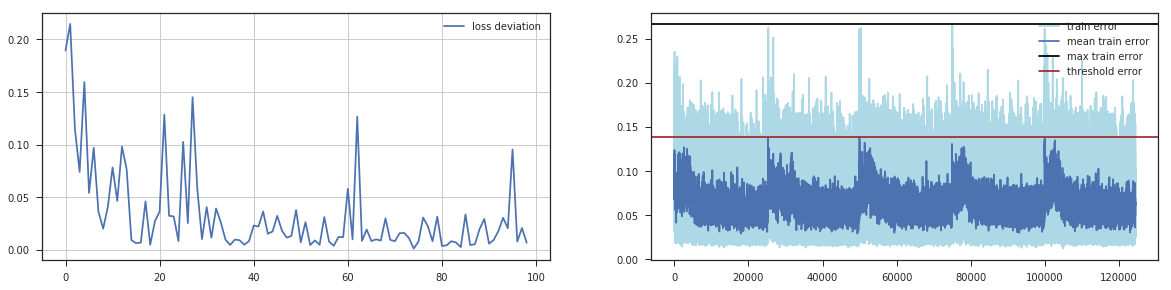

In [9]:
autoencoder, threshold_error = train_autoencoder(traindata)

In [10]:
datasets2 = ds.get_datasets(hdfs, "/data/damianp/aggr_flows_pozman")
pprint(datasets2)

defaultdict(None,
            {0: '/data/damianp/aggr_flows_pozman/table-Mon-Jul-17-15-13-54-2017.csv',
             1: '/data/damianp/aggr_flows_pozman/table-Mon-Jul-17-15-50-58-2017.csv',
             2: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-09-13-34-2017.csv',
             3: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-10-50-30-2017.csv',
             4: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-12-12-39-2017.csv',
             5: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-13-06-52-2017.csv',
             6: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-07-31-16-2017.csv',
             7: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-08-16-15-2017.csv',
             8: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-09-23-35-2017.csv',
             9: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-10-16-55-2017.csv',
             10: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-11-20-17-2017.csv',
             11: '/data/damianp/agg

** Check prediction error for datasets basing on a set of normal POZMAN traffic from 18-20 July 2017 **

Skipped flows: 496 from 29168 (1.70%)
Percent above threshold: 2.713449%


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


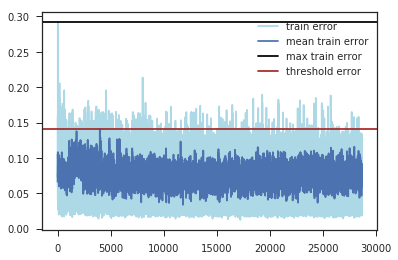

Skipped flows: 908 from 25478 (3.56%)
Percent above threshold: 1.648352%


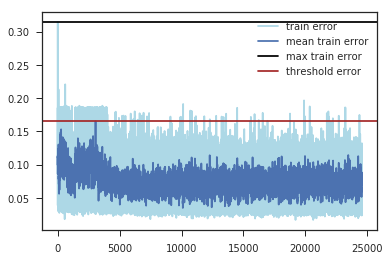

Skipped flows: 508 from 28006 (1.81%)
Percent above threshold: 4.676704%


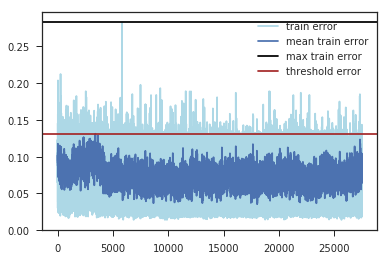

Skipped flows: 1065 from 28214 (3.77%)
Percent above threshold: 5.130944%


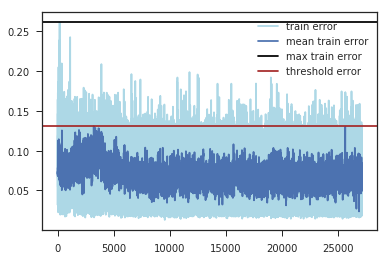

Skipped flows: 501 from 29129 (1.72%)
Percent above threshold: 4.128825%


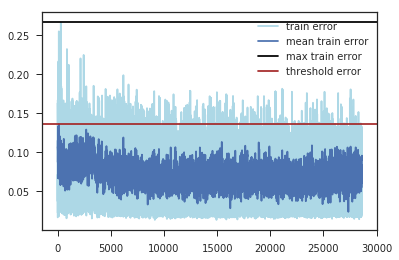

Skipped flows: 510 from 26067 (1.96%)
Percent above threshold: 17.243808%


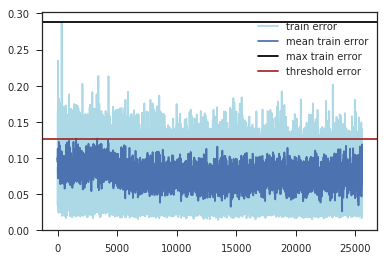

Skipped flows: 367 from 20046 (1.83%)
Percent above threshold: 5.340719%


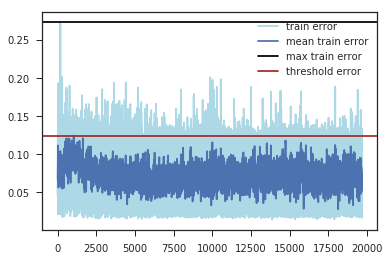

Skipped flows: 418 from 23812 (1.76%)
Percent above threshold: 4.035223%


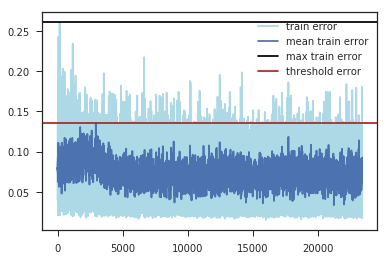

Skipped flows: 576 from 27830 (2.07%)
Percent above threshold: 1.225508%


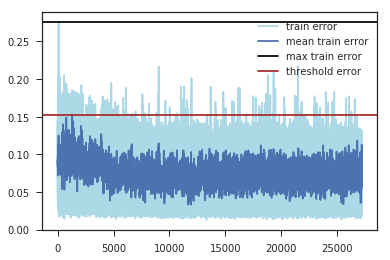

Skipped flows: 607 from 28182 (2.15%)
Percent above threshold: 5.758840%


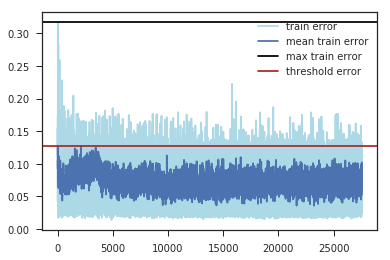

Skipped flows: 575 from 28181 (2.04%)
Percent above threshold: 4.828660%


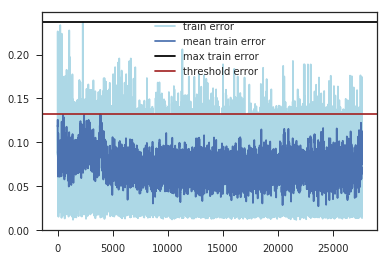

Skipped flows: 857 from 30630 (2.80%)
Percent above threshold: 4.833238%


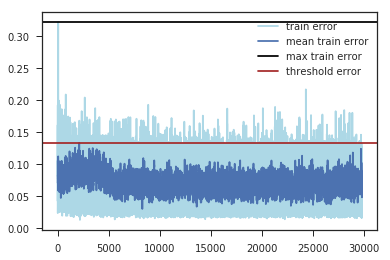

Skipped flows: 709 from 29624 (2.39%)
Percent above threshold: 5.893135%


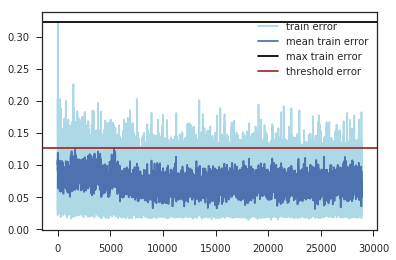

Skipped flows: 345 from 19083 (1.81%)
Percent above threshold: 16.271747%


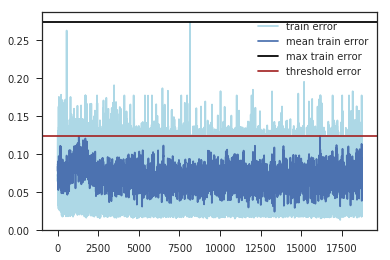

Skipped flows: 495 from 28041 (1.77%)
Percent above threshold: 4.258332%


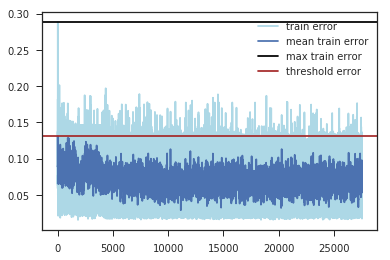

Skipped flows: 742 from 26709 (2.78%)
Percent above threshold: 4.028190%


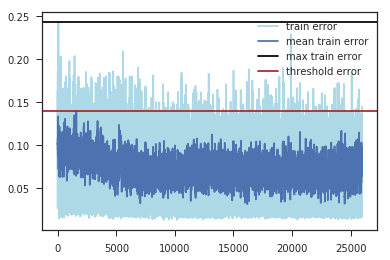

Skipped flows: 447 from 30738 (1.45%)
Percent above threshold: 4.120036%


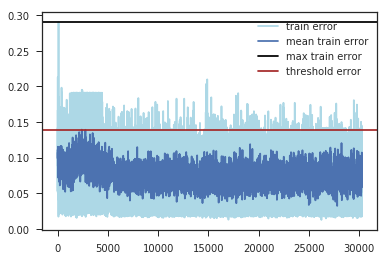

Skipped flows: 570 from 29940 (1.90%)
Percent above threshold: 5.563500%


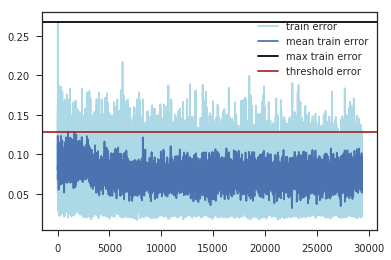

Skipped flows: 500 from 27089 (1.85%)
Percent above threshold: 4.351424%


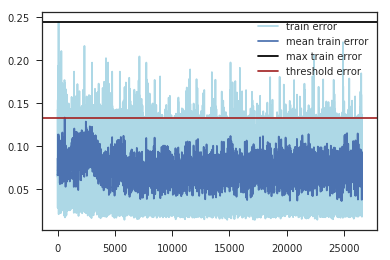

In [11]:
for file in datasets2.values():
    testdata, _features = ds.prepare_dataset(hdfs, file, features, 
                                                       flow_modification_f=modify_flow, skip_flow_f=skip_list)
    scoretrain = np.array(autoencoder.score(testdata))
    
    max_scoretrain = max(scoretrain)
    scoretrain2 = ds.movingaverage(scoretrain, window=10)
    threshold_error = max(scoretrain2)
    
    print("Percent above threshold: %f%%" % (100.0*len(scoretrain[scoretrain > threshold_error])/len(scoretrain)))

    plt.plot(np.array(scoretrain), color='lightblue', label='train error')
    plt.plot(scoretrain2, label='mean train error')
    plt.axhline(max_scoretrain, color='black', label='max train error')
    plt.axhline(threshold_error, color='brown', label='threshold error')
    plt.legend()
    plt.show()